#**Multiclass classification**: brain tumors



**Task 1** : classification of brain tumors in 4 categories (no tumor, pituitarty, glioma, meningioma). Three different CNNs are used. The first one is a standard sequential CNN, the second and the third one are pre-trained networks (MobileNetV2 and VGG16).
The ROC curve and the confusion matrix are studied in all the cases to evalute the performance of the networks.


Images are MRI scans from kaggle in jpg format organized in 4 folders, that represent the labels of the images.
To improve the overfitting data augmentation is performed.


Dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/AI_exam_project

Mounted at /content/drive
/content/drive/MyDrive/AI_exam_project


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm
from tensorflow.keras import layers, models
import tensorflow as tf

from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

## Data preparation


In [3]:
# Data augmentation parameters to improve the overfitting

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)


In [3]:
### Data preparation ###

train_dir = "archive-2/Training"

test_dir = "archive-2/Testing"

# Get the list of subdirectories (labels) in the training directory
labels = os.listdir(train_dir)


# Initialize lists to store image data and corresponding labels
train_images = []
train_labels = []
test_images = []
test_labels = []

class_mapping = {}

# Iterate over the subdirectories
for i, label in tqdm(enumerate(labels)):
    # Get the directory path for the current label in the training directory
    train_label_dir = os.path.join(train_dir, label)
    class_mapping[i] = label

    # Get the directory path for the current label in the test directory
    test_label_dir = os.path.join(test_dir, label)

    # Iterate over the files in the training directory
    for filename in os.listdir(train_label_dir):
        # Get the path
        image_path = os.path.join(train_label_dir, filename)

        # Load the image
        image = load_img(image_path, target_size=(224, 224))

        # Convert the image to a numpy array
        image = img_to_array(image)
        #image = cv2.resize(image,(150,150))
        #image = image / 255.0

        # Append the image and label
        train_images.append(image)
        train_labels.append(i)  # Use the index as the label

    # Iterate over the files in the test directory
    for filename in os.listdir(test_label_dir):
        # Get the path
        image_path = os.path.join(test_label_dir, filename)

        # Load the image
        image = load_img(image_path, target_size=(224, 224))

        # Convert in numpy array
        image = img_to_array(image)
        #image = cv2.resize(image,(150,150))
        #image = image / 255.0

        # Append the image and label
        train_images.append(image)
        train_labels.append(i)  # Use the index as the label

# Convert to numpy arrays
train_images = np.array(train_images)/255.
train_labels = np.array(train_labels)
#test_images = np.array(test_images)
#test_labels = np.array(test_labels)


4it [02:07, 31.93s/it]


In [4]:
X_train,X_test,y_train,y_test = train_test_split(train_images, train_labels, test_size=0.1,random_state=101)

# MyCNN

In [5]:
## My CNN ##

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

batch_size=64

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)


# Fit the model with augmented data generator
model.fit(
    X_train, y_train, batch_size=batch_size,
    #steps_per_epoch=len(train_images) // batch_size,
    epochs=15,
    validation_data=(X_test, y_test),
    callbacks=[tensorboard,checkpoint,reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(np.array(X_test), y_test)
print("Test accuracy:", test_acc)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 24s 233ms/step - loss: 1.0444 - accuracy: 0.5567 - val_loss: 0.6920 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 2/15
47/47 [==============================] - ETA: 0s - loss: 0.5355 - accuracy: 0.8010
Epoch 2: val_accuracy improved from 0.72036 to 0.82371, saving model to effnet.h5
47/47 [==============================] - 9s 188ms/step - loss: 0.5355 - accuracy: 0.8010 - val_loss: 0.4561 - val_accuracy: 0.8237 - lr: 0.0010
Epoch 3/15
46/47 [============================>.] - ETA: 0s - loss: 0.2845 - accuracy: 0.9046
Epoch 3: val_accuracy improved from 0.82371 to 0.86626, saving model to effnet.h5
47/47 [==============================] - 10s 218ms/step - loss: 0.2835 - accuracy: 0.9049 - val_loss: 0.4886 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 4/15
46/47 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9501
Epoch 4: val_accuracy improved from 0.86626 to 0.91185, saving model to effnet.h5
47/47 [==============================]

11/11 [==============================] - 0s 24ms/step
[[1.9601066e-06 2.5405141e-03 6.6523139e-06 9.9745089e-01]
 [2.1963961e-06 1.0848831e-07 8.7542709e-08 9.9999762e-01]
 [2.2465096e-09 9.9999893e-01 1.0665203e-06 1.3777107e-09]
 ...
 [9.9998796e-01 7.6889670e-08 1.1956348e-05 8.7669719e-11]
 [9.6063669e-12 1.1183217e-09 6.0294530e-10 1.0000000e+00]
 [2.0599414e-03 6.3636573e-05 9.9787641e-01 3.9836593e-08]]


ValueError: ignored

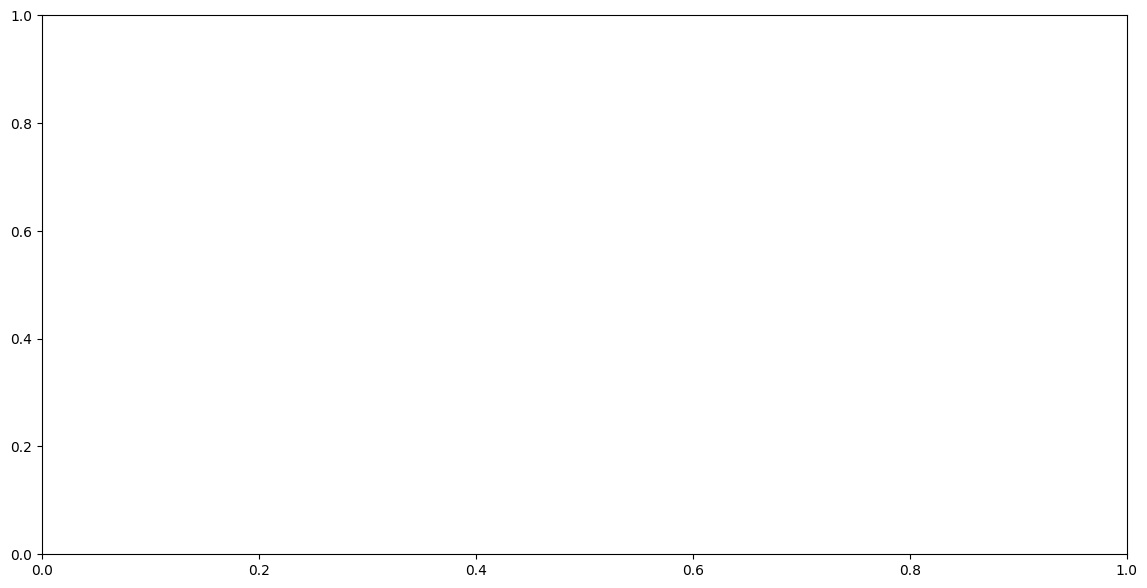

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test, pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True, linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28)

plt.show()

In [ ]:
!cd Trained_models_tumor_classification
model.save('My_CNN_task1.keras')

In [ ]:
!cd Trained_models_tumor_classification
model = tf.keras.models.load_model('My_CNN_task1.keras')

11/11 [==============================] - 0s 39ms/step


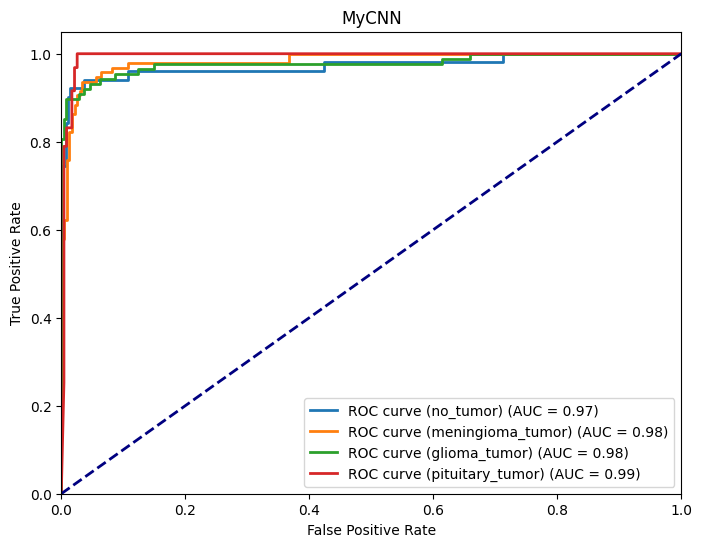

In [12]:
# MyCNN ROC curve

from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize


# Make predictions
predictions = model.predict(X_test)

num_classes = len(labels)


# Convert labels to one-hot encoded format
test_labels_one_hot = label_binarize(y_test, classes=list(range(num_classes)))

# Initialize variables to store ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve ({labels[i]}) (AUC = {roc_auc[i]:.2f})')


# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MyCNN')
plt.legend(loc='lower right')
plt.savefig('ROC_MyCNN.pdf')
plt.show()


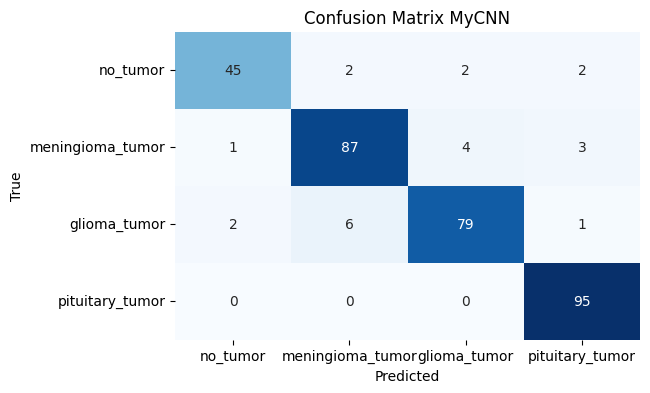

In [13]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(np.argmax(test_labels_one_hot, axis=1), np.argmax(predictions, axis=1))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes)+0.5, [labels[i] for i in range(num_classes)], rotation=0)
plt.yticks(np.arange(num_classes)+0.5, [labels[i] for i in range(num_classes)], rotation=0)
plt.title('Confusion Matrix MyCNN')
plt.savefig('Confusion_matrix_MyCNN.pdf')
plt.show()

# Pre-trained MobileNetV2

In [ ]:
# Load the pre-trained MobileNetV2 model

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Perform data augmentation and train the model
batch_size = 32
steps_per_epoch = len(train_images) // batch_size

# Fit the model with augmented data generator
model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(test_images, test_labels)
)


Epoch 1/50
90/90 [==============================] - 46s 461ms/step - loss: 1.7453 - accuracy: 0.5140 - val_loss: 1.7738 - val_accuracy: 0.4695
Epoch 2/50
90/90 [==============================] - 36s 399ms/step - loss: 0.9144 - accuracy: 0.6218 - val_loss: 1.0996 - val_accuracy: 0.5279
Epoch 3/50
90/90 [==============================] - 39s 429ms/step - loss: 0.7345 - accuracy: 0.6686 - val_loss: 1.6473 - val_accuracy: 0.4975
Epoch 4/50
90/90 [==============================] - 37s 415ms/step - loss: 0.7222 - accuracy: 0.6826 - val_loss: 1.4265 - val_accuracy: 0.5431
Epoch 5/50
90/90 [==============================] - 37s 407ms/step - loss: 0.6435 - accuracy: 0.7117 - val_loss: 1.2181 - val_accuracy: 0.5635
Epoch 6/50
90/90 [==============================] - 39s 427ms/step - loss: 0.6704 - accuracy: 0.7029 - val_loss: 1.4728 - val_accuracy: 0.5457
Epoch 7/50
90/90 [==============================] - 40s 442ms/step - loss: 0.6057 - accuracy: 0.7159 - val_loss: 1.7970 - val_accuracy: 0.5888

In [ ]:
%cd Trained_models_tumor_classification

model.save('MobileNetV2_task1.keras')
%cd ..

/content/drive/MyDrive/AI_exam_project/Trained_models_tumor_classification
/content/drive/MyDrive/AI_exam_project


In [ ]:
%cd Trained_models_tumor_classification

model = tf.keras.models.load_model('MobileNetV2_task1.keras')
%cd ..

/content/drive/MyDrive/AI_exam_project/Trained_models_tumor_classification
/content/drive/MyDrive/AI_exam_project


13/13 [==============================] - 1s 46ms/step


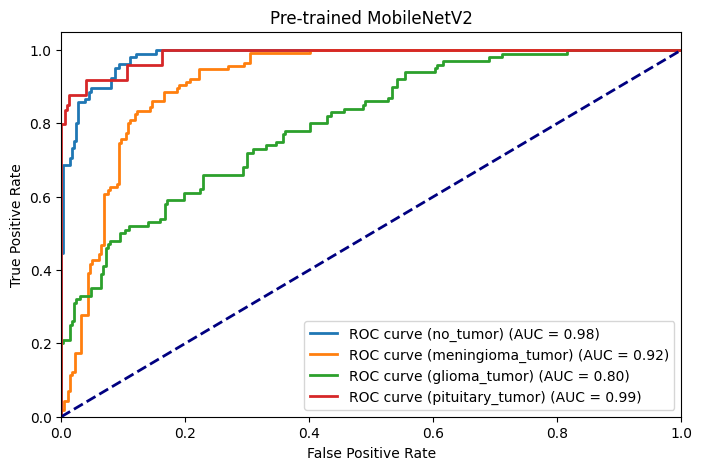

In [ ]:
# Make predictions
predictions = model.predict(test_images)

num_classes = len(labels)

# Convert labels to one-hot encoded format
test_labels_one_hot = label_binarize(test_labels, classes=list(range(num_classes)))

# Initialize variables to store ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 5))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve ({class_mapping[i]}) (AUC = {roc_auc[i]:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pre-trained MobileNetV2')
plt.legend(loc='lower right')
plt.savefig('ROC_MobileNetV2.pdf')
plt.show()

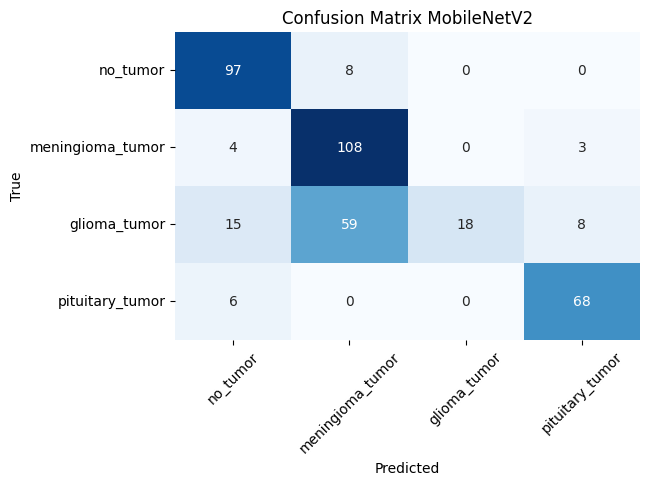

In [ ]:
# Confusion matrix MobileNetV2



plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(np.argmax(test_labels_one_hot, axis=1), np.argmax(predictions, axis=1))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes)+0.5, [class_mapping[i] for i in range(num_classes)], rotation=45)
plt.yticks(np.arange(num_classes)+0.5, [class_mapping[i] for i in range(num_classes)], rotation=0)
plt.title('Confusion Matrix MobileNetV2')
plt.savefig('Confusion_Matrix_MobileNetV2.pdf')
plt.show()


In [ ]:
predicted_labels = model.predict(test_images)
predicted_classes = [np.argmax(label) for label in predicted_labels]
actual_classes = [label for label in test_labels]

predicted_class_names = [class_mapping[label] for label in predicted_classes]
actual_class_names = [class_mapping[label] for label in actual_classes]

print(classification_report(actual_class_names, predicted_class_names))

13/13 [==============================] - 1s 43ms/step
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.18      0.31       100
meningioma_tumor       0.62      0.94      0.74       115
        no_tumor       0.80      0.92      0.85       105
 pituitary_tumor       0.86      0.92      0.89        74

        accuracy                           0.74       394
       macro avg       0.82      0.74      0.70       394
    weighted avg       0.81      0.74      0.69       394



# Pre-trained VGG16

In [ ]:
## TRAINING VGG16 ##

# pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Perform data augmentation and train the model
batch_size = 32
steps_per_epoch = len(train_images) // batch_size

# Fit the model with augmented data generator
model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(test_images, test_labels)
)

Epoch 1/50
101/101 [==============================] - 56s 540ms/step - loss: 1.2763 - accuracy: 0.5109 - val_loss: 1.4660 - val_accuracy: 0.3604
Epoch 2/50
101/101 [==============================] - 55s 545ms/step - loss: 0.8880 - accuracy: 0.6350 - val_loss: 1.3701 - val_accuracy: 0.4162
Epoch 3/50
101/101 [==============================] - 44s 432ms/step - loss: 0.7954 - accuracy: 0.6744 - val_loss: 1.2680 - val_accuracy: 0.5533
Epoch 4/50
101/101 [==============================] - 43s 423ms/step - loss: 0.6958 - accuracy: 0.7120 - val_loss: 1.1426 - val_accuracy: 0.5990
Epoch 5/50
101/101 [==============================] - 42s 412ms/step - loss: 0.6715 - accuracy: 0.7163 - val_loss: 1.1398 - val_accuracy: 0.5888
Epoch 6/50
101/101 [==============================] - 43s 421ms/step - loss: 0.6436 - accuracy: 0.7327 - val_loss: 1.1532 - val_accuracy: 0.5558
Epoch 7/50
101/101 [==============================] - 43s 422ms/step - loss: 0.6203 - accuracy: 0.7408 - val_loss: 1.1353 - val_ac

In [ ]:
%cd Trained_models_tumor_classification
model.save('VGG16_task1.keras')
%cd ..

In [ ]:
%cd Trained_models_tumor_classification
model = tf.keras.models.load_model('VGG16_task1.keras')
%cd ..

In [ ]:
# Make predictions
predictions = model.predict(test_images)

num_classes = len(labels)

# Convert labels to one-hot encoded format
test_labels_one_hot = label_binarize(test_labels, classes=list(range(num_classes)))

# Initialize variables to store ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve ({class_mapping[i]}) (AUC = {roc_auc[i]:.2f})')


# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16')
plt.legend(loc='lower right')
plt.savefig('ROC_VGG16.pdf')
plt.show()

In [ ]:
# Confusion matrix VGG16

from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(np.argmax(test_labels_one_hot, axis=1), np.argmax(predictions, axis=1))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes)+0.5, [class_mapping[i] for i in range(num_classes)], rotation=0)
plt.yticks(np.arange(num_classes)+0.5, [class_mapping[i] for i in range(num_classes)], rotation=0)
plt.title('Confusion Matrix VGG16')
plt.savefig('Confusion_Matrix_VGG16.pdf')
plt.show()

# Open an image

[1. 0. 0. 0.]
[0. 0. 1. 0.]


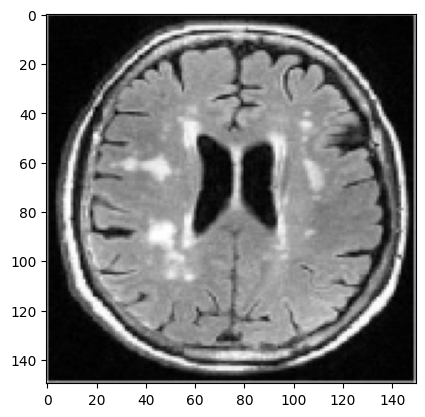

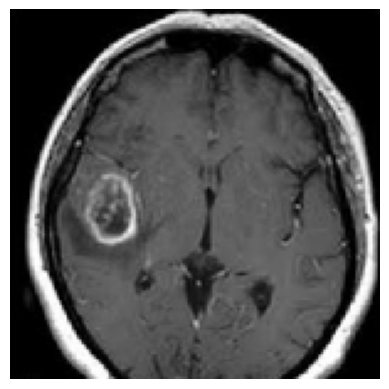

In [43]:
#Open an image

i= 0

image1 = test_images[i]/255.
label1 = test_labels[i]
img2 = X_test[i]/255.
label2 = y_test[i]
print(label1)
print(label2)
# Convert label index to label name
#label_name1 = labels[label1]

# Plot the image with the corresponding label
plt.imshow(image1)
plt.show()
plt.imshow(img2)
#plt.title("Label: " + label_name1)
plt.axis("off")
plt.show()


1/1 [==============================] - 1s 768ms/step
Correct Label: glioma_tumor


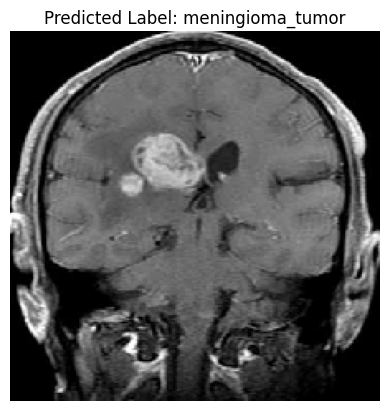

In [ ]:
### prediction ###

image_pr = np.expand_dims(image1, axis=0)

# Make predictions
predictions = model.predict(image_pr)

# Get the predicted label
label_names = labels
predicted_label_index = np.argmax(predictions[0])
predicted_label = label_names[predicted_label_index]

print("Correct Label: " + label_name1)

# Plot
plt.imshow(image_pr[0])
plt.axis('off')
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

# Remove no tumor class
In this section I'm removing the no_tumor class

In [ ]:
### Data preparation 3 classes (only tumors) ###

train_dir = "archive-2/Training"

test_dir = "archive-2/Testing"

# Get the list of subdirectories (labels) in the training directory
labels = os.listdir(train_dir)
labels.remove("no_tumor")

# Initialize lists to store image data and corresponding labels
train_images = []
train_labels = []
test_images = []
test_labels = []

tumor_mapping = {}

# Iterate over the subdirectories
for i, label in tqdm(enumerate(labels)):
    # Get the directory path for the current label in the training directory
    train_label_dir = os.path.join(train_dir, label)

    # Get the directory path for the current label in the test directory
    test_label_dir = os.path.join(test_dir, label)
    tumor_mapping[i] = label

    # Iterate over the files in the training directory
    for filename in os.listdir(train_label_dir):
        # Get the path
        image_path = os.path.join(train_label_dir, filename)

        # Load the image
        image = load_img(image_path, target_size=(224, 224))

        # Convert the image to a numpy array
        image = img_to_array(image)
        image = image / 255.0

        # Append the image and label
        train_images.append(image)
        train_labels.append(i)  # Use the index as the label

    # Iterate over the files in the test directory
    for filename in os.listdir(test_label_dir):
        # Get the path
        image_path = os.path.join(test_label_dir, filename)

        # Load the image
        image = load_img(image_path, target_size=(224, 224))

        # Convert in numpy array
        image = img_to_array(image)
        image = image / 255.0

        # Append the image and label
        test_images.append(image)
        test_labels.append(i)  # Use the index as the label

# Convert to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Example data splitting
from sklearn.model_selection import train_test_split
#train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


3it [01:51, 37.00s/it]


In [ ]:
# Load the pre-trained MobileNetV2 model

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
steps_per_epoch = len(train_images) // batch_size

# Fit the model with augmented data generator
model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(test_images, test_labels)
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
77/77 [==============================] - 45s 432ms/step - loss: 2.4447 - accuracy: 0.5757 - val_loss: 1.2364 - val_accuracy: 0.4567
Epoch 2/50
77/77 [==============================] - 34s 441ms/step - loss: 0.6919 - accuracy: 0.7259 - val_loss: 2.4694 - val_accuracy: 0.6055
Epoch 3/50
77/77 [==============================] - 37s 482ms/step - loss: 0.5826 - accuracy: 0.7402 - val_loss: 2.8987 - val_accuracy: 0.5363
Epoch 4/50
77/77 [==============================] - 34s 443ms/step - loss: 0.5153 - accuracy: 0.7933 - val_loss: 1.5900 - val_accuracy: 0.6574
Epoch 5/50
77/77 [==============================] - 34s 446ms/step - loss: 0.4931 - accuracy: 0.7950 - val_loss: 2.2513 - val_accuracy: 0.6228
Epoch 6/50
77/77 [==============================] - 33s 433ms/step - loss: 0.4698 - accuracy: 0.7933 - val_loss: 2.0802 - val_accuracy: 0.6090
Epoch 7/50
77/77 [==============================] - 34s 448ms/step - loss: 0.48

In [ ]:
%cd Trained_models_tumor_classification
model.save('Onlytumors_task1_MobileNet.keras')
%cd ..

/content/drive/MyDrive/AI_exam_project/Trained_models_tumor_classification
/content/drive/MyDrive/AI_exam_project


In [ ]:
%cd Trained_models_tumor_classification
model = tf.keras.models.load_model('Onlytumors_task1_MobileNet.keras')
%cd ..

/content/drive/MyDrive/AI_exam_project/Trained_models_tumor_classification
/content/drive/MyDrive/AI_exam_project


10/10 [==============================] - 1s 61ms/step


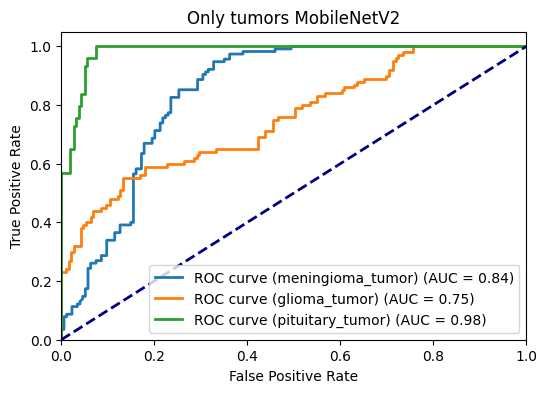

In [ ]:
# Make predictions
predictions = model.predict(test_images)

num_classes = len(labels)

# Convert labels to one-hot encoded format
test_labels_one_hot = label_binarize(test_labels, classes=list(range(num_classes)))

# Initialize variables to store ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(6, 4))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve ({tumor_mapping[i]}) (AUC = {roc_auc[i]:.2f})')


# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Only tumors MobileNetV2')
plt.legend(loc='lower right')
plt.savefig('ROC_Onlytumors.pdf')
plt.show()


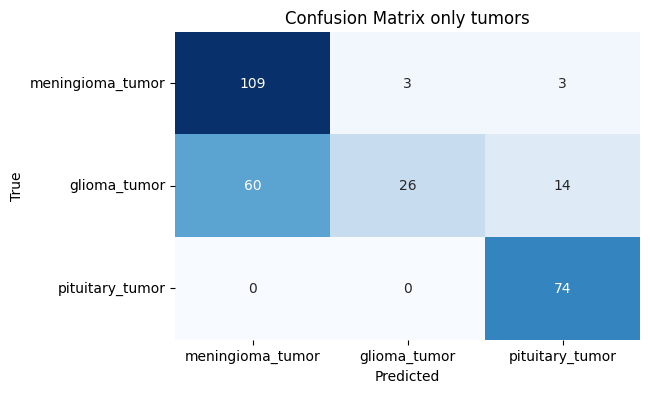

In [ ]:
# Confusion matrix only tumors

from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(np.argmax(test_labels_one_hot, axis=1), np.argmax(predictions, axis=1))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes)+0.5, [tumor_mapping[i] for i in range(num_classes)], rotation=0)
plt.yticks(np.arange(num_classes)+0.5, [tumor_mapping[i] for i in range(num_classes)], rotation=0)
plt.title('Confusion Matrix only tumors')
plt.savefig('Confusion_Matrix_Onlytumors.pdf')
plt.show()


In [ ]:
## My CNN onlytumors ##

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

batch_size=32

# Fit the model with augmented data generator
model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=50,
    validation_data=(np.array(test_images), test_labels)
)

# Evaluate the model
test_loss, test_acc = model.evaluate(np.array(test_images), test_labels)
print("Test accuracy:", test_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
%cd Trained_models_tumor_classification
model.save('Onlytumors_task1_MyCNN.keras')
%cd ..

/content/drive/MyDrive/AI_exam_project/Trained_models_tumor_classification
/content/drive/MyDrive/AI_exam_project


In [ ]:
%cd Trained_models_tumor_classification
model = tf.keras.models.load_model('Onlytumors_task1_MyCNN.keras')
%cd ..

10/10 [==============================] - 0s 17ms/step


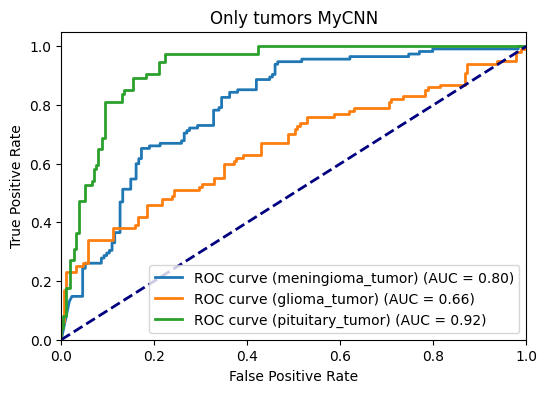

In [ ]:
# Make predictions
predictions = model.predict(test_images)

num_classes = len(labels)

# Convert labels to one-hot encoded format
test_labels_one_hot = label_binarize(test_labels, classes=list(range(num_classes)))

# Initialize variables to store ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(6, 4))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve ({tumor_mapping[i]}) (AUC = {roc_auc[i]:.2f})')


# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Only tumors MyCNN')
plt.legend(loc='lower right')
plt.savefig('ROC_Onlytumors_MyCNN.pdf')
plt.show()

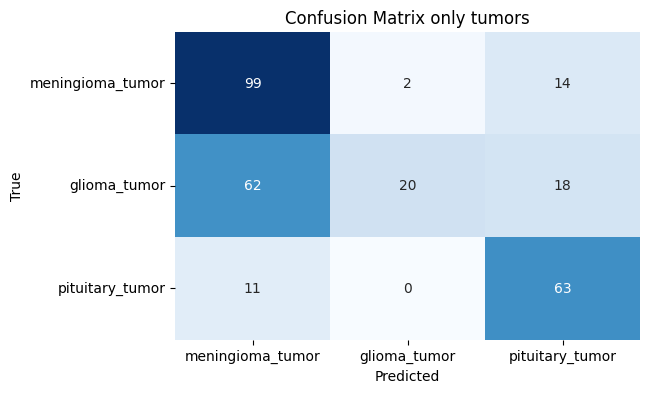

In [ ]:
# Confusion matrix only tumors MyCNN

from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(np.argmax(test_labels_one_hot, axis=1), np.argmax(predictions, axis=1))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(np.arange(num_classes)+0.5, [tumor_mapping[i] for i in range(num_classes)], rotation=0)
plt.yticks(np.arange(num_classes)+0.5, [tumor_mapping[i] for i in range(num_classes)], rotation=0)
plt.title('Confusion Matrix only tumors')
plt.savefig('Confusion_Matrix_Onlytumors_MyCNN.pdf')
plt.show()